# Let's actually do sentiment prediction based on movie reviews

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Eager mode:  True
Hub version:  0.7.0
GPU is NOT AVAILABLE


In [2]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

In [3]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [4]:
train_examples[:10]

array([b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a clich\xc3\xa9, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not

In [5]:
train_labels[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

* https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1
* https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1 - same, but with 2.5% vocabulary converted to OOV buckets.
* https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1 - A much larger model with ~1M vocabulary size and 50 dimensions.
* https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1 - Even larger model with ~1M vocabulary size and 128 dimensions.

In [6]:
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: id=303, shape=(3, 20), dtype=float32, numpy=
array([[ 3.9819887 , -4.4838037 ,  5.177359  , -2.3643482 , -3.2938678 ,
        -3.5364532 , -2.4786978 ,  2.5525482 ,  6.688532  , -2.3076782 ,
        -1.9807833 ,  1.1315885 , -3.0339816 , -0.7604128 , -5.743445  ,
         3.4242578 ,  4.790099  , -4.03061   , -5.992149  , -1.7297493 ],
       [ 3.4232912 , -4.230874  ,  4.1488533 , -0.29553518, -6.802391  ,
        -2.5163853 , -4.4002395 ,  1.905792  ,  4.7512794 , -0.40538004,
        -4.3401685 ,  1.0361497 ,  0.9744097 ,  0.71507156, -6.2657013 ,
         0.16533905,  4.560262  , -1.3106939 , -3.1121316 , -2.1338716 ],
       [ 3.8508697 , -5.003031  ,  4.8700504 , -0.04324996, -5.893603  ,
        -5.2983093 , -4.004676  ,  4.1236343 ,  6.267754  ,  0.11632943,
        -3.5934832 ,  0.8023905 ,  0.56146765,  0.9192484 , -7.3066816 ,
         2.8202746 ,  6.2000837 , -3.5709393 , -4.564525  , -2.305622  ]],
      dtype=float32)>

In [7]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [10]:
print(x_val.shape)

(10000,)


In [11]:
%%time
# ~1 minute
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 2s 150us/sample - loss: 1.0169 - accuracy: 0.5727 - val_loss: 0.7266 - val_accuracy: 0.5966
Epoch 2/40
15000/15000 [==============================] - 1s 97us/sample - loss: 0.6639 - accuracy: 0.6367 - val_loss: 0.6367 - val_accuracy: 0.6582
Epoch 3/40
15000/15000 [==============================] - 1s 98us/sample - loss: 0.6173 - accuracy: 0.6645 - val_loss: 0.6033 - val_accuracy: 0.6840
Epoch 4/40
15000/15000 [==============================] - 1s 94us/sample - loss: 0.5845 - accuracy: 0.6909 - val_loss: 0.5756 - val_accuracy: 0.7101
Epoch 5/40
15000/15000 [==============================] - 1s 94us/sample - loss: 0.5539 - accuracy: 0.7222 - val_loss: 0.5508 - val_accuracy: 0.7301
Epoch 6/40
15000/15000 [==============================] - 1s 95us/sample - loss: 0.5229 - accuracy: 0.7487 - val_loss: 0.5252 - val_accuracy: 0.7455
Epoch 7/40
15000/15000 [==============================]

In [12]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.37507408984184265, 0.86092]


In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

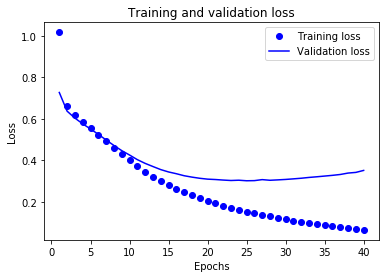

In [14]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

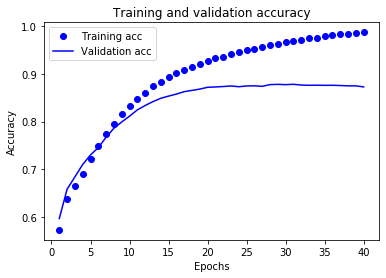

In [15]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
partial_x_train[1]

b"Outside of the fact that George Lopez is a pretentious jerk, his show is terrible.<br /><br />Nothing about Lopez has ever been funny. I have watched his stand-up and have never uttered any resemblance to a laugh.<br /><br />His stuff comes across as vindictive and his animosity towards white people oozes out of every single pore of his body.<br /><br />I have laughed at white people jokes from many a comedian and love many of them.<br /><br />This guy has a grudge that won't end.<br /><br />I feel bad for Hispanics who have only this show to represent themselves.<br /><br />The shows plots are always cookie cutter with an Hispanic accent.<br /><br />Canned laugh at the dumbest comments and scenes.<br /><br />Might be why this show is always on at 2AM in replay."

In [17]:
partial_y_train[1]

0

In [18]:
model.predict(partial_x_train[0:3])


array([[0.00243256],
       [0.12461526],
       [0.99865204]], dtype=float32)

In [19]:
partial_x_train[2]

b'As we all know the sub-genre of sex comedies is pretty crowded. Simply being excessively raunchy isn\'t enough anymore. I\'ve seen and heard so many disgusting jokes and actions that a sex comedy really needs to have other positive points to appeal to me these days.<br /><br />Coming into the 40 Year Old Virgin I knew basically what to expect; I did see the commercials after all; "is it true that if you don\'t use it, you lose it?" What I didn\'t expect to find is a heart and honest attempts at character development. There\'s still the weird "off-the-wall" characters that we see so much in Adam Sandler movies and there\'s still enough inappropriate language to sink Noah\'s Ark but somehow the movie has a worthwhile love story and yes even a message.<br /><br />The main character Andy is (unfortunately for me) a person I can relate to. In the first shot I see that he even shares my love for Mystery Science Theater 3000 (he has a poster for the movie on his wall) and throughout the mov

In [20]:
%precision 7
np.set_printoptions(precision=4, suppress=True)
model.predict(['good movie','bad actor', 'I would love to see more action.'])

array([[0.8562],
       [0.01  ],
       [0.9305]], dtype=float32)

In [21]:
model.predict(['good movie but bad actor', 'bad movie but good actor'])

array([[0.0455],
       [0.0455]], dtype=float32)

In [24]:
model.predict(['Good', 'good'])

array([[0.8888],
       [0.9403]], dtype=float32)